<a href="https://colab.research.google.com/github/behdad13/time-series-forecasting/blob/main/FCN_LSTM_BO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## importing necessary libraries 

In [3]:
#installing necessary libraries
!pip install torch
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#import necessary libraries
import os
import random
import time
import pandas as pd
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from numpy import array
from sklearn.preprocessing import MinMaxScaler
import optuna
from optuna.trial import TrialState
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.nn.functional as F
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [5]:
#set seed
seed_val = 67
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## importing pre-processed dataset

In [6]:
#import the dataset
data = pd.read_csv('Data_Toronto.csv', low_memory=False)

#select the most relevent feature from the dataset
data = data[['Year', 'Month', 'Day', 'Hour', 'week_end','temperature', 'humidex', 'Ontario_Real_price', 'Electricity_Load']]

In [7]:
#define the test and train set
seq = 5*24
horizon = 24
train = data.iloc[17520+8760+8786 - seq : 43824 + horizon]
test = data.iloc[43824 - seq : 43824+30*24 + horizon]

## train-val-test split

In [8]:
#defining the training proportion
#seperating train and validation set
train_size = int(len(data)*0.80)      
valid_size = int(len(data)*0.20)
df_train, df_val = data[:train_size], data[train_size+1:]
df_train.shape, df_val.shape, test.shape

((38534, 9), (9633, 9), (864, 9))

In [9]:
# scaling each features of the dataset
scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train),index = df_train.index, columns = df_train.columns)
df_val = pd.DataFrame(scaler.transform(df_val),index = df_val.index, columns = df_val.columns)
test = pd.DataFrame(scaler.transform(test),index = test.index, columns = test.columns)

## Make a time sequneces

In [10]:
df_train = df_train.to_numpy()
df_val = df_val.to_numpy()
test = test.to_numpy()

In [11]:
# split a multivariate sequence into samples
from numpy import array
def split_sequences(sequences, n_steps, for_hor):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-for_hor:
            break
        # gather input and output parts of the pattern
        # sequence_x ranges from 0 to seq_len and all columns except the last one.
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:end_ix+for_hor, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [12]:
n_timesteps = 24*5
for_hor = 24
X_train, y_train = split_sequences(df_train, n_timesteps, for_hor)
X_val, y_val = split_sequences(df_val, n_timesteps, for_hor)
X_test, y_test = split_sequences(test, n_timesteps, for_hor)

In [13]:
print(X_test.shape, y_test.shape)

(721, 120, 9) (721, 24)


In [14]:
n_timesteps + len(X_train) + for_hor-1 == len(df_train)

True

 ## Data Loader

In [15]:
from torch.utils.data import TensorDataset, DataLoader
import torch

batch_size = 64


X_train_t = torch.Tensor(X_train)
y_train_t = torch.Tensor(y_train)
X_val_t = torch.Tensor(X_val)
y_val_t = torch.Tensor(y_val)
X_test_t = torch.Tensor(X_test)
y_test_t = torch.Tensor(y_test)

train = TensorDataset(X_train_t, y_train_t)
val = TensorDataset(X_val_t, y_val_t)
test_w1 = TensorDataset(X_test_t, y_test_t)


train_loader = DataLoader(train, batch_size=batch_size, shuffle = True, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle = False, drop_last=True)
test_loader_one_w1 = DataLoader(test_w1, batch_size=1, shuffle = False, drop_last=True)

In [16]:
#check the size of the train set
X_train_t.shape, y_train_t.shape

(torch.Size([38391, 120, 9]), torch.Size([38391, 24]))

In [17]:
#just for testing the size of the batch
next(iter(train_loader))[1].size(), next(iter(train_loader))[0].size()

(torch.Size([64, 24]), torch.Size([64, 120, 9]))

## deep learning model

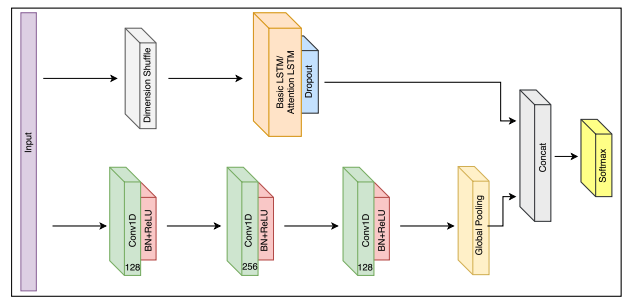

The follwoing code has some minor differences with the model because it works for a classification problem not a regression one.
1. BN(batch normalization is not considered.
2. A linear leyer after the concatenation is considered instead of GP (global pooling). However, GP is coded for further usages.
3. Softmax layer is not considered becuase of the regression problem.
4. The base article consider the univaraite input data for the FCN layer but I consider multivariate one.

In [18]:
#making a global average plooing layer 
class GlobalAveragePooling1D(nn.Module):
    def __init__(self, data_format='channels_last'):
        super(GlobalAveragePooling1D, self).__init__()

        self.data_format = data_format
        self.step_axis = 1 if self.data_format == 'channels_last' else 2

    def forward(self, input):
        return torch.mean(input, axis=self.step_axis)



#here is the code for a ConvBlock
#batch-normalization is removerd from the code becasue it worsens the results.
class ConvBlock(nn.Module):
    def __init__(self, ni, nf, ks, drop=0.):
        super(ConvBlock, self).__init__()

        self.conv1d = nn.Conv1d(ni,nf,ks)
        self.dropout = nn.Dropout(drop)
        self.batch_norm = nn.BatchNorm1d(nf)
        self.relu = nn.ReLU()
        self.cpad1d = nn.ConstantPad1d(((ks-1), 0), 0)  
        self.init_weights

    def init_weights(self):
        self.conv1d.weight.data.normal_(0, 0.01)

    def forward(self, x):
        x = self.cpad1d(self.conv1d(x))
        x = self.dropout(x)
        #x = self.batch_norm(x)  #batch normalization
        x = self.relu(x)
        return x


#main
class FCNLSTM(nn.Module):
    def __init__(self, c_in, c_out, seq_len, hidden_layer, layers=[128, 256, 128], kss=[7, 5, 3], drop=0.):
        super(FCNLSTM, self).__init__()
        assert len(layers) == len(kss)

        self.convblock1 = ConvBlock(c_in, layers[0], kss[0])
        self.convblock2 = ConvBlock(layers[0], layers[1], kss[1])
        self.convblock3 = ConvBlock(layers[1], layers[2], kss[2])
        self.GAP1D = GlobalAveragePooling1D()
        self.fc = nn.Linear((layers[-1]+hidden_layer)*seq_len, c_out)                #**NOTE:if you activate the GAP layer, remove 'seq_len' from the linear layer
        self.lstm = nn.LSTM(input_size=c_in, hidden_size=hidden_layer, num_layers=1)
        self.dropout = nn.Dropout(drop)

    def forward(self, x):
        x1 = x.permute(0, 2, 1)                 #FCN stream
        x1 = self.convblock1(x1)
        x1 = self.convblock2(x1)
        x1 = self.convblock3(x1)
        x1 = x1.permute(0, 2, 1)

        x, (_, _) = self.lstm(x)                #Basic LSTM stream
        x = self.dropout(x)

        out = torch.cat((x1, x), 2)             #concatenation 
        out = torch.flatten(out, start_dim=1)    #**NOTE:if you activate the GAP layer, deactive the layer
        #out = self.GAP1D(x)      
        return self.fc(out)

In [19]:
#for testing the dimension of ConvBlock
#x = torch.rand(64, 9,120)
#model = ConvBlock(ni = 9,
#                nf =64, 
#                ks = 9)

#y = model(x)
#y.shape

In [20]:
#checking dimensions of FCN layers
x = torch.rand(64, 120, 9)
model = FCNLSTM(c_in = 9,
            hidden_layer=128,    
            seq_len = 120, 
            layers=[128, 256, 128],
            kss=[7, 5, 3],
            c_out=24)
y = model(x)
y.shape

torch.Size([64, 24])

In [23]:
#defining an objective function of the bayesian Optimization and which parameters need to be tuned
epochs = 250 
patience = 20
loss = nn.MSELoss()
min_val_loss_total=np.inf

def objective(trial):
    #define the infinity variable
    min_val_loss = np.inf


    # Generate the model.
    model = FCNLSTM(c_in = 9, 
                seq_len=120,
                hidden_layer = trial.suggest_int("hidden_size_lstm", 16, 128),
                layers=[128, 256, 128],
                kss=[7, 5, 3],
                c_out=24).cuda()
                #hidden_size2 = trial.suggest_int("hidden_dim2", 16, 128),    

    # Generate the optimizers.
    loss_fn = nn.MSELoss() 
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # Training of the model
    counter = 0
    for i in range(epochs):
        mse_train = 0
        iteration_start = time.monotonic()
        for batch_x, batch_y in train_loader :
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            opt.zero_grad()
            y_pred = model(batch_x)
            y_pred = y_pred.squeeze(1)
            l = loss(y_pred, batch_y)
            l.backward()
            mse_train += l.item()*batch_x.shape[0]
            opt.step()
        with torch.no_grad():
            mse_val = 0
            preds = []
            true = []
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()
                output = model(batch_x)
                output = output.squeeze(1)
                preds.append(output.detach().cpu().numpy())
                true.append(batch_y.detach().cpu().numpy())
                mse_val += loss(output, batch_y).item()*batch_x.shape[0]
        preds = np.concatenate(preds)
        true = np.concatenate(true)

        if min_val_loss > mse_val:
            min_val_loss = mse_val
            counter = 0
        else: 
            counter += 1
        if counter == patience:
            break   

        global min_val_loss_total
        if min_val_loss_total > mse_val:
            min_val_loss_total = mse_val
            torch.save(model.state_dict(), "FCNLSTM_BO.pt")

        if i % 20 == 0:
            print("Iter: ", i, "train: ", (mse_train), "val: ", (mse_val))
        
        if trial.should_prune():
            raise optuna.TrialPruned()
            
        trial.report(min_val_loss, i)
        
    return min_val_loss

In [24]:
if __name__ == "__main__":
    #create the study
    study = optuna.create_study(direction="minimize", 
                                sampler=optuna.samplers.TPESampler(), 
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))

    #calling the optimzation process
    study.optimize(objective, n_trials=40)  

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-12-27 16:03:12,779] A new study created in memory with name: no-name-0c3cd9b6-8c54-4325-bb61-3feaa25e95bc


Iter:  0 train:  324.6928213387728 val:  46.3376597315073
Iter:  20 train:  35.989619359374046 val:  29.215595858171582


[I 2022-12-27 16:06:10,559] Trial 0 finished with value: 26.809945423156023 and parameters: {'hidden_size_lstm': 54, 'lr': 2.802601583000008e-05}. Best is trial 0 with value: 26.809945423156023.


Iter:  0 train:  214.4439689591527 val:  33.987076411023736
Iter:  20 train:  10.09442516323179 val:  41.60255211405456


[I 2022-12-27 16:08:45,466] Trial 1 finished with value: 27.55132632702589 and parameters: {'hidden_size_lstm': 114, 'lr': 8.177489547353578e-05}. Best is trial 0 with value: 26.809945423156023.


Iter:  0 train:  323.1101643741131 val:  48.48077343404293
Iter:  20 train:  42.84058837220073 val:  28.97157454676926


[I 2022-12-27 16:11:36,076] Trial 2 finished with value: 27.035459622740746 and parameters: {'hidden_size_lstm': 91, 'lr': 2.406177722066732e-05}. Best is trial 0 with value: 26.809945423156023.


Iter:  0 train:  191.17258171737194 val:  39.31841291487217
Iter:  20 train:  7.820889032445848 val:  46.12844502739608


[I 2022-12-27 16:13:43,587] Trial 3 finished with value: 26.901180730201304 and parameters: {'hidden_size_lstm': 96, 'lr': 0.00011908349853803647}. Best is trial 0 with value: 26.809945423156023.


Iter:  0 train:  187.63581173866987 val:  36.650425136089325
Iter:  20 train:  6.088832956273109 val:  40.69794033654034


[I 2022-12-27 16:15:30,315] Trial 4 finished with value: 28.885513991117477 and parameters: {'hidden_size_lstm': 49, 'lr': 0.00014671802795504914}. Best is trial 0 with value: 26.809945423156023.


Iter:  0 train:  165.0460260808468 val:  34.34311970695853


[I 2022-12-27 16:16:06,170] Trial 5 pruned. 


Iter:  0 train:  430.8459502607584 val:  52.49499859660864


[I 2022-12-27 16:16:50,970] Trial 6 pruned. 


Iter:  0 train:  487.2600075751543 val:  58.30974495783448


[I 2022-12-27 16:17:35,028] Trial 7 pruned. 


Iter:  0 train:  265.4549650400877 val:  39.10001471452415
Iter:  20 train:  27.518859524279833 val:  29.633817557245493


[I 2022-12-27 16:19:54,158] Trial 8 finished with value: 26.529335644096136 and parameters: {'hidden_size_lstm': 59, 'lr': 4.20918715824805e-05}. Best is trial 8 with value: 26.529335644096136.


Iter:  0 train:  160.10630195587873 val:  30.310407925397158


[I 2022-12-27 16:20:37,416] Trial 9 pruned. 


Iter:  0 train:  247.09586790204048 val:  37.683290695771575
Iter:  20 train:  21.87378809042275 val:  35.423074001446366


[I 2022-12-27 16:22:50,843] Trial 10 finished with value: 26.632306736893952 and parameters: {'hidden_size_lstm': 26, 'lr': 5.298917894818328e-05}. Best is trial 8 with value: 26.529335644096136.


Iter:  0 train:  248.4141959324479 val:  37.237999491393566


[I 2022-12-27 16:23:24,010] Trial 11 pruned. 


Iter:  0 train:  265.69862312078476 val:  46.56894267350435


[I 2022-12-27 16:23:57,343] Trial 12 pruned. 


Iter:  0 train:  166.2438822388649 val:  39.94711480103433


[I 2022-12-27 16:24:32,509] Trial 13 pruned. 


Iter:  0 train:  321.7238517701626 val:  43.43584184721112


[I 2022-12-27 16:25:06,250] Trial 14 pruned. 


Iter:  0 train:  242.2334774658084 val:  35.60598731972277


[I 2022-12-27 16:25:40,907] Trial 15 pruned. 


Iter:  0 train:  186.10131439566612 val:  33.23228302411735


[I 2022-12-27 16:26:14,258] Trial 16 pruned. 


Iter:  0 train:  353.9434038698673 val:  45.365104615688324


[I 2022-12-27 16:26:51,220] Trial 17 pruned. 


Iter:  0 train:  271.7046585381031 val:  40.28491217084229
Iter:  20 train:  27.38778375647962 val:  34.33873433060944


[I 2022-12-27 16:29:12,196] Trial 18 finished with value: 25.910163888707757 and parameters: {'hidden_size_lstm': 79, 'lr': 4.309645834479027e-05}. Best is trial 18 with value: 25.910163888707757.


Iter:  0 train:  258.45807848125696 val:  40.41747579164803


[I 2022-12-27 16:29:48,498] Trial 19 pruned. 


Iter:  0 train:  217.99342939257622 val:  34.946971917524934


[I 2022-12-27 16:30:25,666] Trial 20 pruned. 


Iter:  0 train:  279.80999026447535 val:  38.57090154848993


[I 2022-12-27 16:31:00,128] Trial 21 pruned. 


Iter:  0 train:  382.9794232994318 val:  46.12814765796065


[I 2022-12-27 16:31:42,375] Trial 22 pruned. 


Iter:  0 train:  232.64581675082445 val:  37.59105428867042


[I 2022-12-27 16:32:18,491] Trial 23 pruned. 


Iter:  0 train:  274.4191989302635 val:  48.682188510894775


[I 2022-12-27 16:32:54,971] Trial 24 pruned. 


Iter:  0 train:  186.24407827854156 val:  34.45723227225244


[I 2022-12-27 16:33:28,268] Trial 25 pruned. 


Iter:  0 train:  211.00431161373854 val:  34.329507851973176


[I 2022-12-27 16:34:02,255] Trial 26 pruned. 


Iter:  0 train:  246.12973334640265 val:  38.88292386755347


[I 2022-12-27 16:34:38,637] Trial 27 pruned. 


Iter:  0 train:  424.15583181381226 val:  50.01844100654125


[I 2022-12-27 16:35:21,392] Trial 28 pruned. 


Iter:  0 train:  321.61487908661366 val:  42.178972847759724


[I 2022-12-27 16:35:55,683] Trial 29 pruned. 


Iter:  0 train:  306.2295692116022 val:  40.011314081028104


[I 2022-12-27 16:36:30,388] Trial 30 pruned. 


Iter:  0 train:  225.2293003499508 val:  39.78397894650698


[I 2022-12-27 16:37:04,546] Trial 31 pruned. 


Iter:  0 train:  359.7768255546689 val:  49.15032935887575


[I 2022-12-27 16:37:38,204] Trial 32 pruned. 


Iter:  0 train:  258.77936613559723 val:  39.76836426369846


[I 2022-12-27 16:38:12,420] Trial 33 pruned. 


Iter:  0 train:  317.6449489146471 val:  44.87485955283046


[I 2022-12-27 16:38:47,206] Trial 34 pruned. 


Iter:  0 train:  208.80644144117832 val:  31.707836681976914


[I 2022-12-27 16:39:49,506] Trial 35 pruned. 


Iter:  0 train:  204.65801695734262 val:  35.62367219850421


[I 2022-12-27 16:40:26,549] Trial 36 pruned. 


Iter:  0 train:  219.20745277404785 val:  35.69931342639029


[I 2022-12-27 16:41:02,512] Trial 37 pruned. 


Iter:  0 train:  351.9624355137348 val:  46.95960721373558


[I 2022-12-27 16:41:36,537] Trial 38 pruned. 


Iter:  0 train:  256.6923522427678 val:  40.618920005857944


[I 2022-12-27 16:42:13,817] Trial 39 pruned. 


Study statistics: 
  Number of finished trials:  40
  Number of pruned trials:  32
  Number of complete trials:  8
Best trial:
  Value:  25.910163888707757
  Params: 
    hidden_size_lstm: 79
    lr: 4.309645834479027e-05


<ipython-input-25-d49b120290e8>:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=[ "hidden_size_lstm", "lr" ])


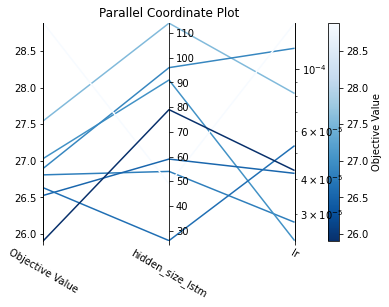

In [25]:
#Visualizing sets of tunned yperparameters based on the BO
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=[ "hidden_size_lstm", "lr" ])
optuna.visualization.plot_param_importances(study)

In [ ]:
#Download the PT file
from google.colab import files
files.download('FCNLSTM_BO.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
#Read the pk file
model = FCNLSTM(c_in = 9, 
                seq_len=120,
                hidden_layer=79,
                layers=[128, 256, 128],
                kss=[7, 5, 3],
                c_out=24)

model.load_state_dict(torch.load("FCNLSTM_BO.pt"))

<All keys matched successfully>

In [28]:
#call a desacaler function for the further analysis
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

In [29]:
# the error calculation function
def calculate_metrics(values_descaled, prediction_descaled):
    result_metrics = {
                      'MAE' : mean_absolute_error(values_descaled, prediction_descaled),
                      'MSE' : mean_squared_error(values_descaled, prediction_descaled),
                      'R2'  : r2_score(values_descaled, prediction_descaled),
                      'MAPE': mean_absolute_percentage_error(values_descaled, prediction_descaled)
                      }
    print("Root Mean Squared Error :  ", result_metrics["MSE"]**0.5)
    print("R^2                :       ", result_metrics["R2"])
    print("Mean Absolute Error:       ", result_metrics["MAE"])
    print("MAPE               :       ", result_metrics["MAPE"])
    
    return result_metrics

Test set results

In [30]:
# feeding the model with the test set.
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y in test_loader_one_w1:
        batch_x = batch_x
        batch_y = batch_y
        output = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
preds = np.concatenate(preds)
true = np.concatenate(true)

Illustration of one-step, two-step, three-step, and 24-step ahead forecasting

error for next 1 hour prediction
Root Mean Squared Error :   171.0533368800081
R^2                :        0.9428079791530499
Mean Absolute Error:        137.87511749902478
MAPE               :        0.0233706330512167


error for next 2 hour prediction
Root Mean Squared Error :   172.85767927498432
R^2                :        0.9411940245876488
Mean Absolute Error:        140.41744660735958
MAPE               :        0.023764709564994758


error for next 3 hour prediction
Root Mean Squared Error :   168.92181656109756
R^2                :        0.9437088043434073
Mean Absolute Error:        137.3740471404733
MAPE               :        0.023207626489403426


error for next 24 hour prediction
Root Mean Squared Error :   224.01967349807558
R^2                :        0.8960065262105193
Mean Absolute Error:        178.7207275052011
MAPE               :        0.03041075898435602


1-step ahead forecast
2-step ahead forecast
3-step ahead forecast
24-step ahead forecast


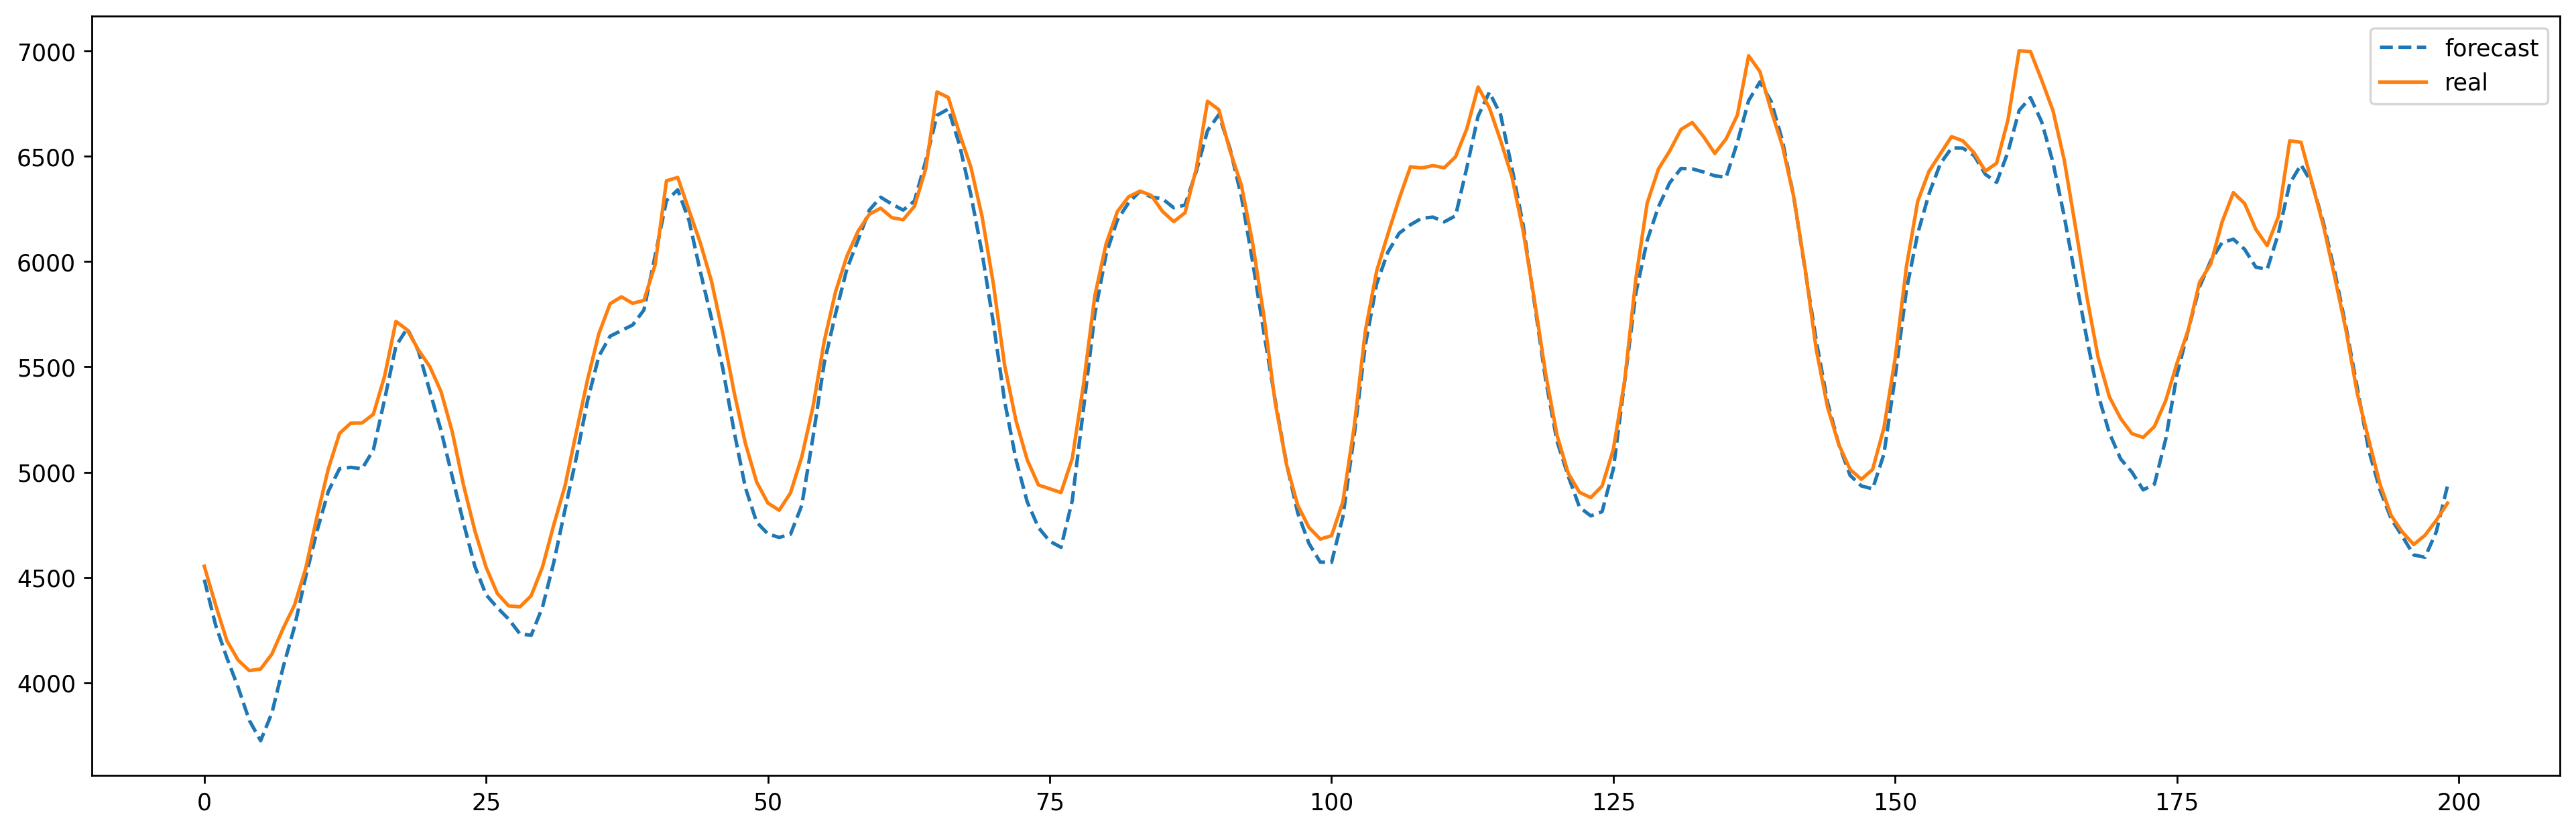

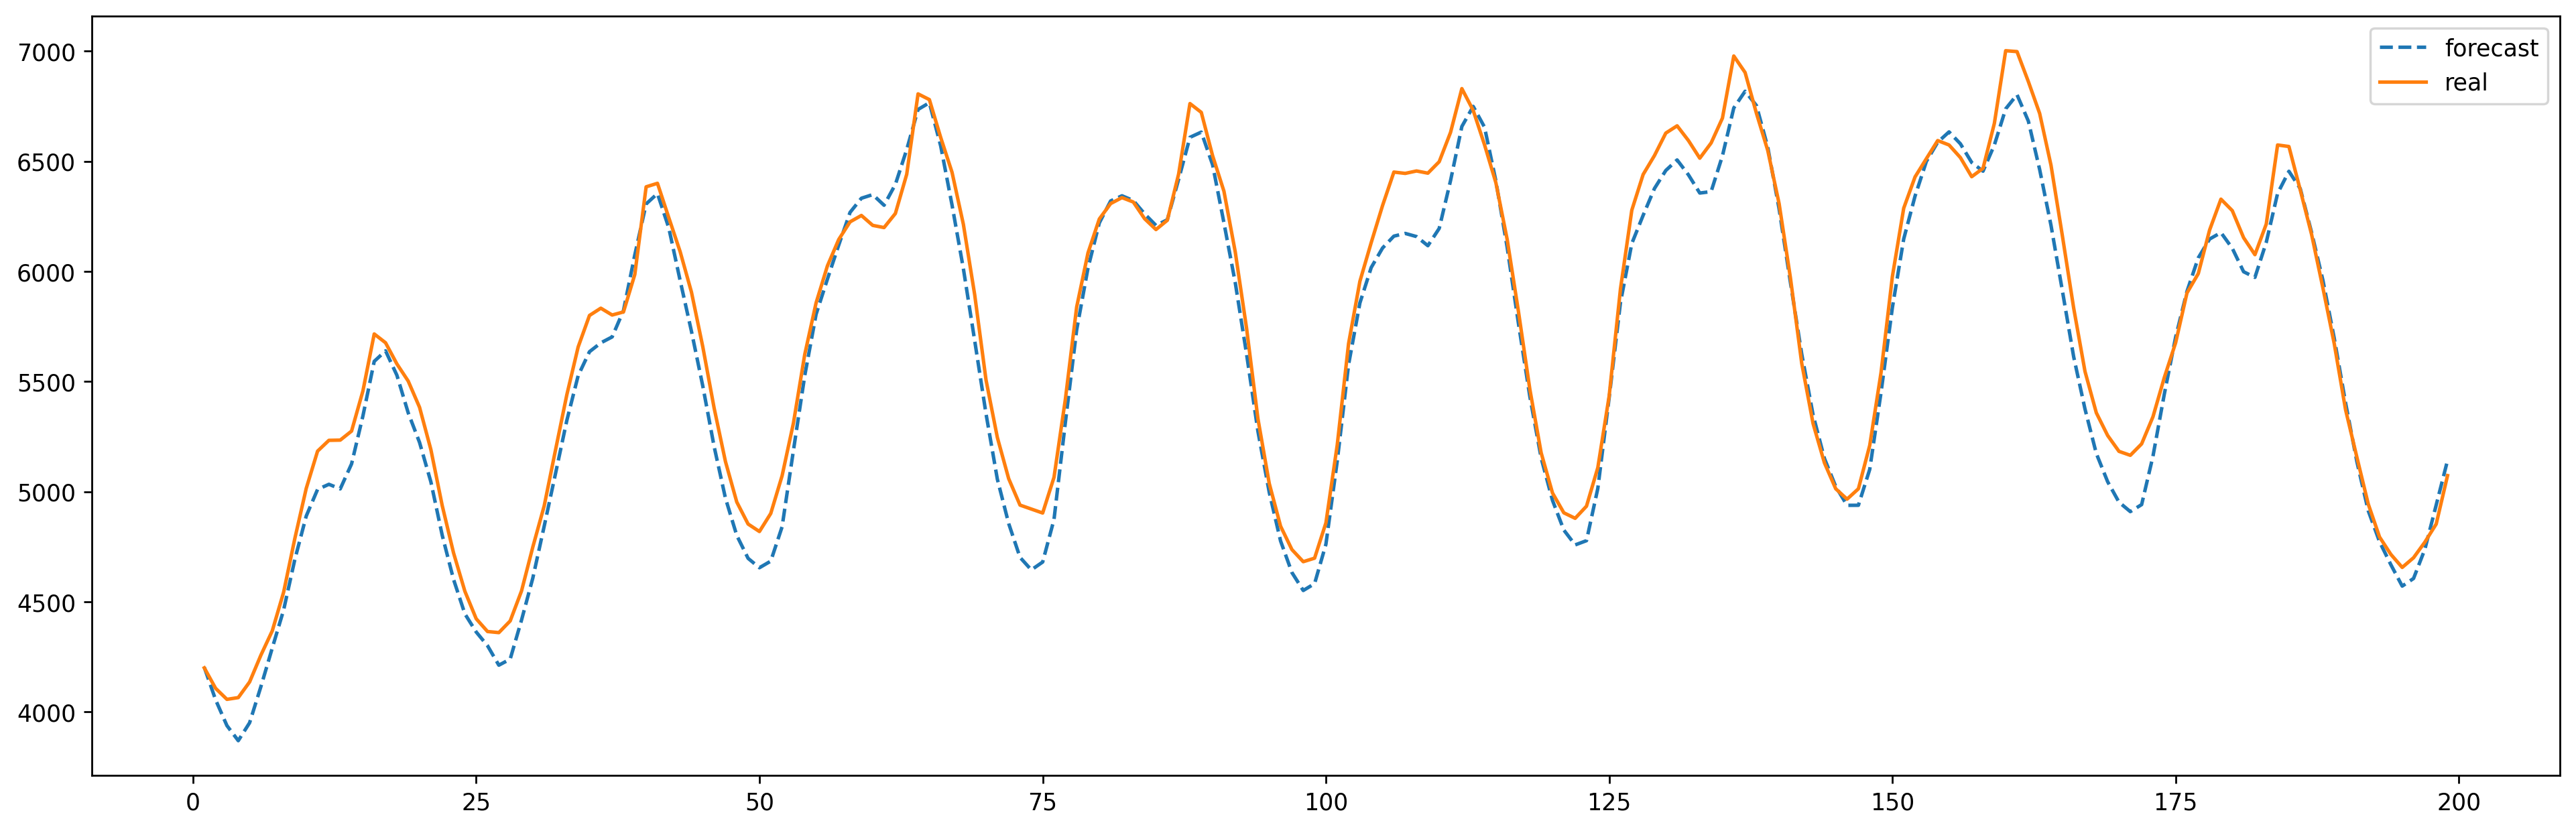

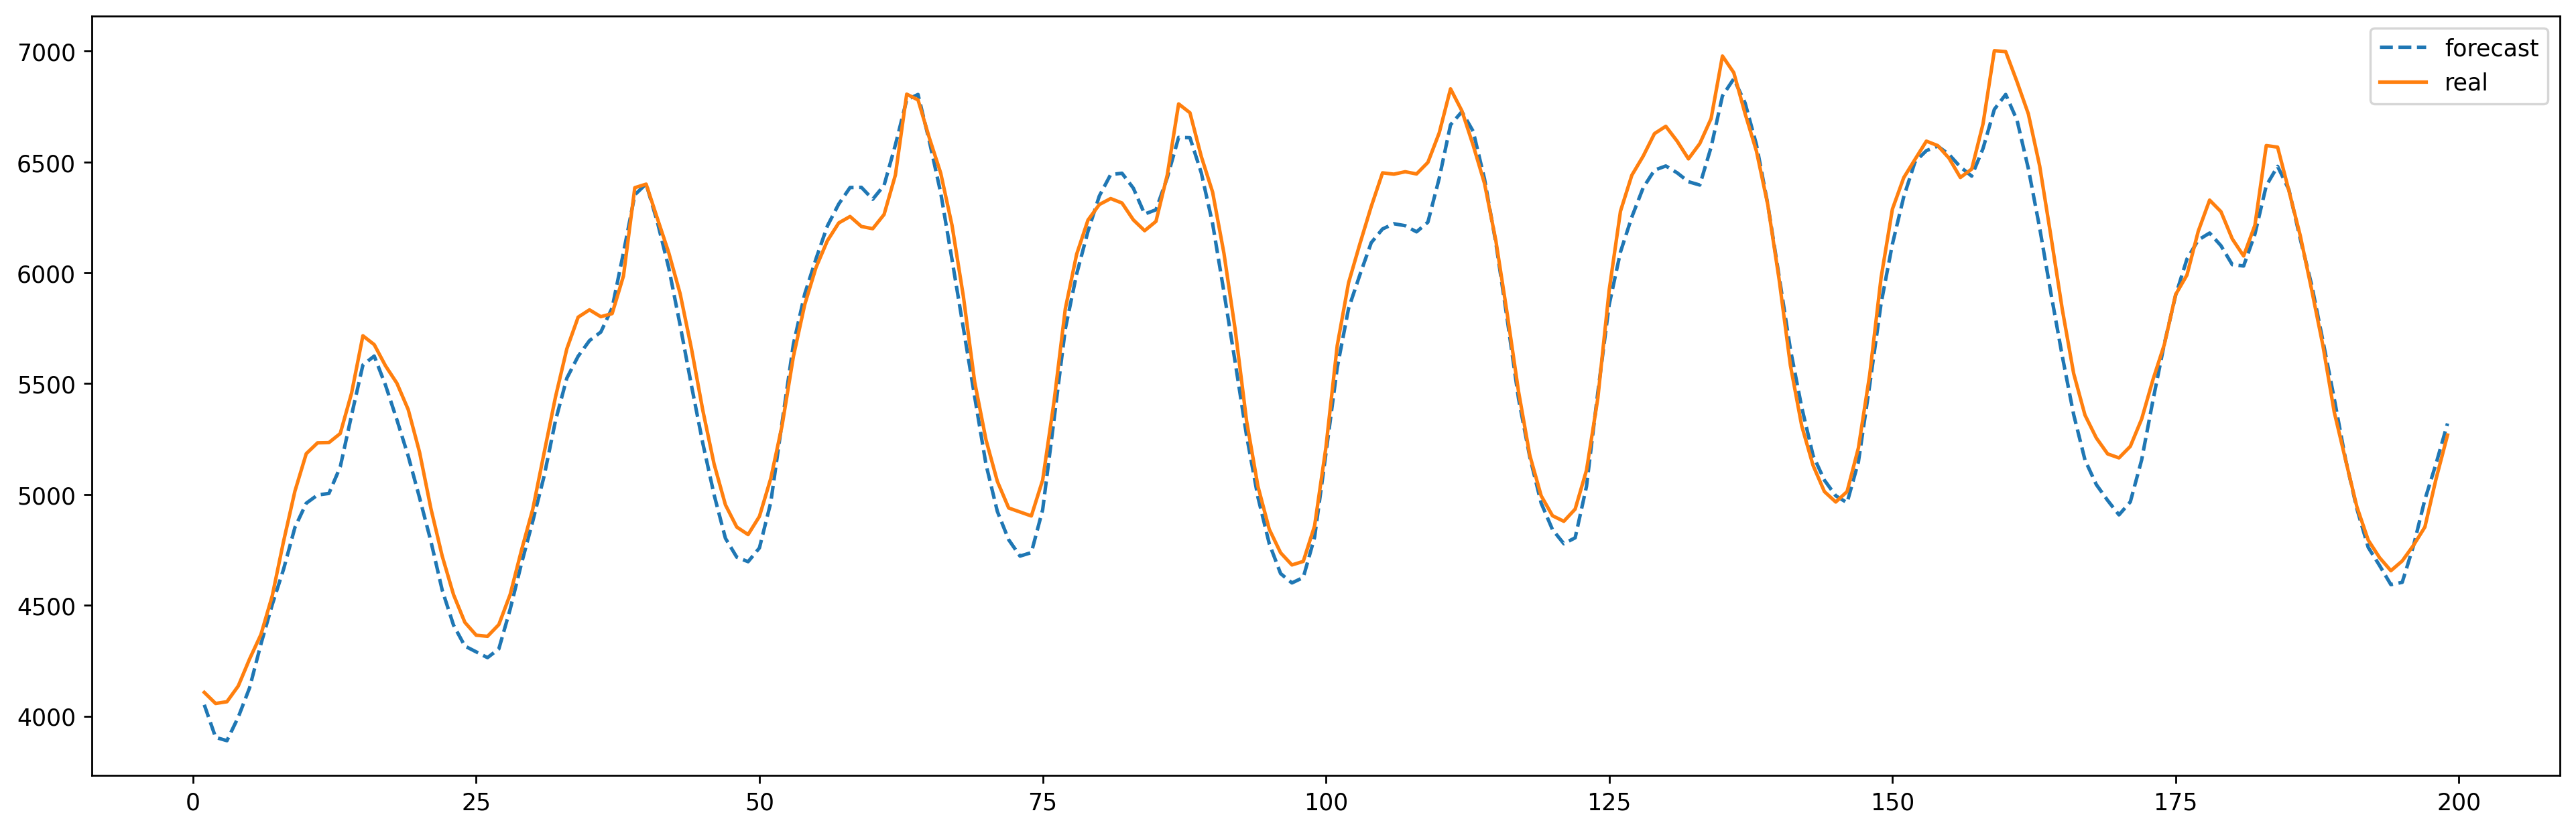

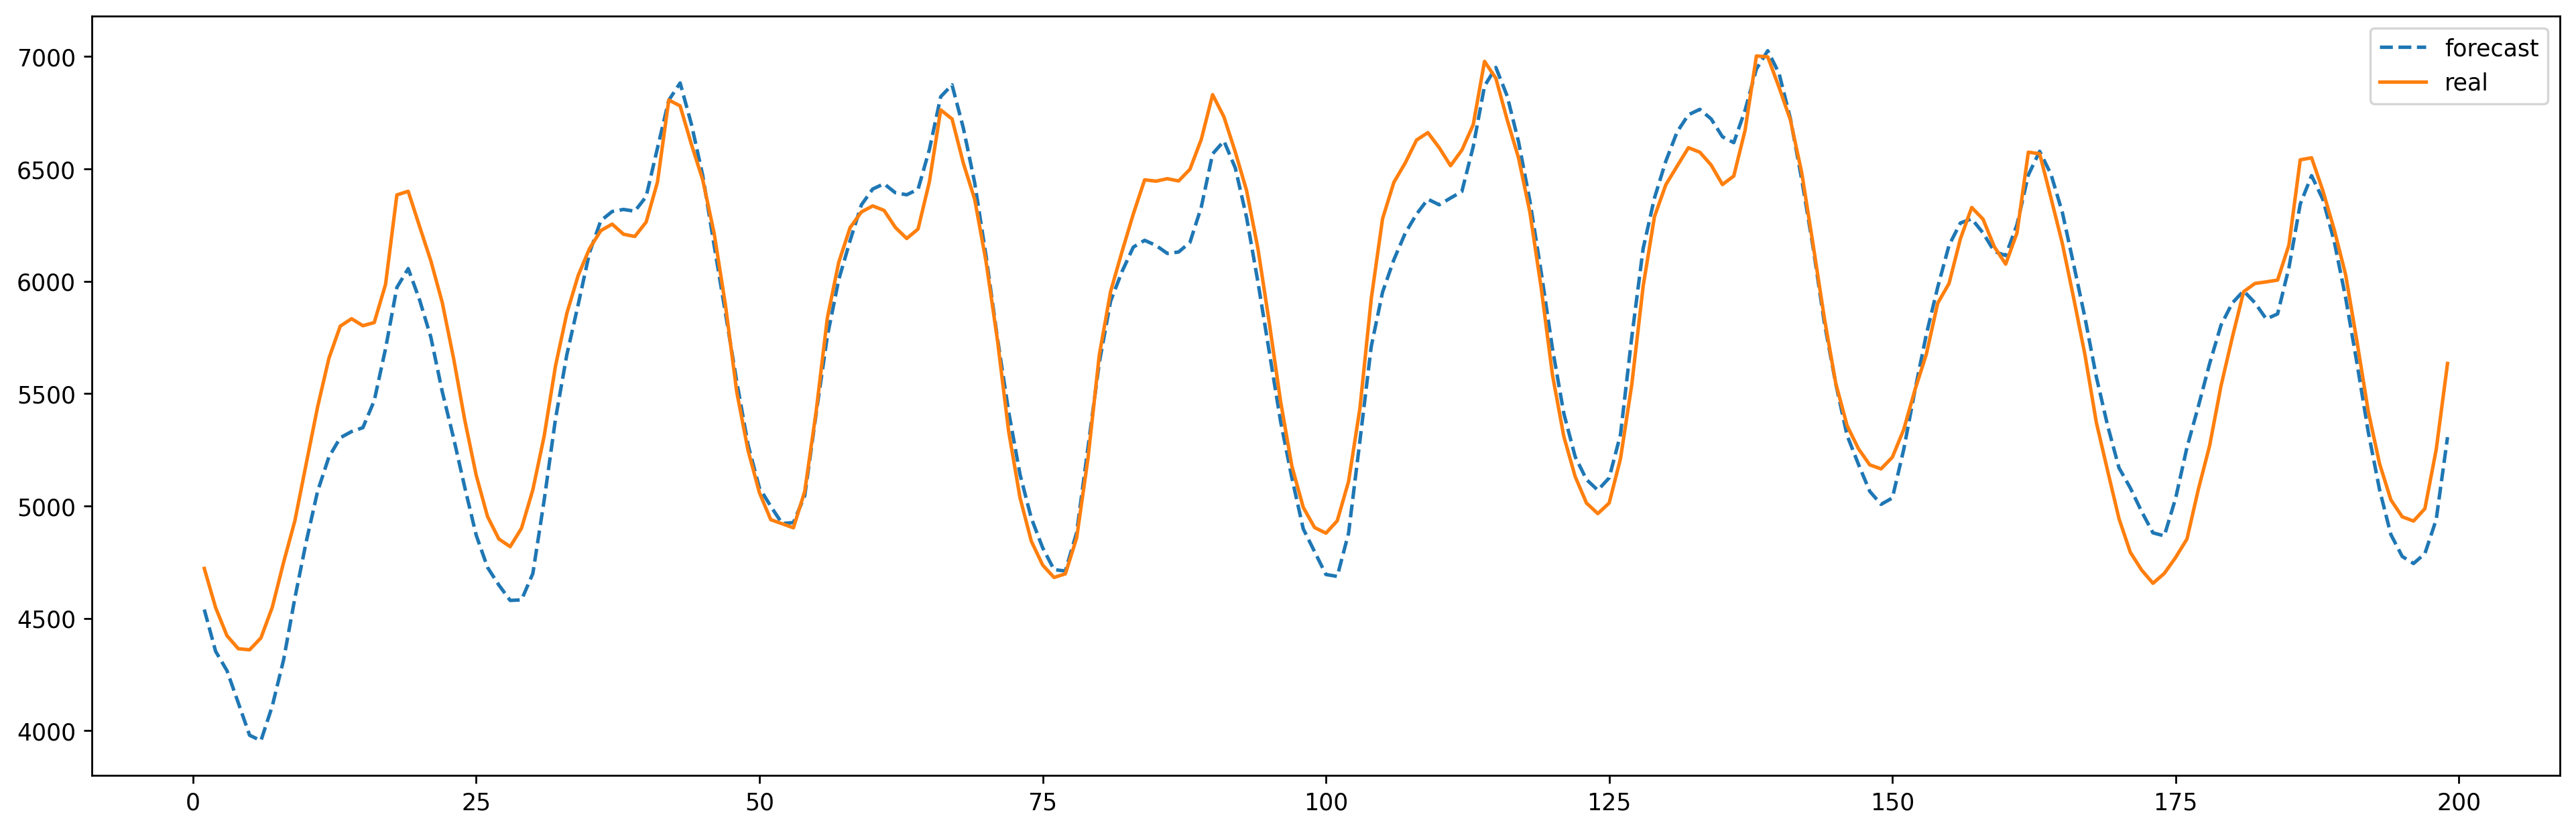

In [31]:
# create an empty dataframe  
df = pd.DataFrame()
df['forcasted_demand_1h'] = 0
df['forcasted_demand_2h'] = 0
df['forcasted_demand_3h'] = 0
df['forcasted_demand_24h'] = 0
df['real_demand_1h'] = 0
df['real_demand_2h'] = 0
df['real_demand_3h'] = 0
df['real_demand_24h'] = 0

for i in range(len(preds)):
    prediction_descaled=[]
    values_descaled=[]
    prediction_descaled = descale(descaler, preds[[i]].reshape(-1))
    values_descaled = descale(descaler, true[[i]].reshape(-1))
    new_row = {'forcasted_demand_1h':prediction_descaled[0], 
           'forcasted_demand_2h':prediction_descaled[1], 
           'forcasted_demand_3h':prediction_descaled[2],
           'forcasted_demand_24h':prediction_descaled[23],
           'real_demand_1h' : values_descaled[0],
           'real_demand_2h' : values_descaled[1],
           'real_demand_3h' : values_descaled[2],
           'real_demand_24h' : values_descaled[23]}
    
    df = df.append(new_row, ignore_index=True)

print('error for next 1 hour prediction')
error_1h = calculate_metrics(df.forcasted_demand_1h,df.real_demand_1h )
print("\n")
print('error for next 2 hour prediction')
error_2h = calculate_metrics(df.forcasted_demand_2h,df.real_demand_2h )
print("\n")
print('error for next 3 hour prediction')
error_3h = calculate_metrics(df.forcasted_demand_3h,df.real_demand_3h )
print("\n")
print('error for next 24 hour prediction')
error_24h = calculate_metrics(df.forcasted_demand_24h,df.real_demand_24h )
print("\n")



print('1-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_1h))
plt.plot(dates[0:200], df.forcasted_demand_1h[0:200], "--", label="forecast")
plt.plot(dates[0:200], df.real_demand_1h[0:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

print('2-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_1h))
plt.plot(dates[1:200], df.forcasted_demand_2h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_2h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

print('3-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_3h))
plt.plot(dates[1:200], df.forcasted_demand_3h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_3h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();


print('24-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_24h))
plt.plot(dates[1:200], df.forcasted_demand_24h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_24h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

Visualizing the seires (the next 24-hour forecast)

In [32]:
prediction_descaled=[]
values_descaled=[]
for i in range(len(preds)):
    prediction_descaled.append(descale(descaler, preds[[i]].reshape(-1)))
    values_descaled.append(descale(descaler, true[[i]].reshape(-1)))

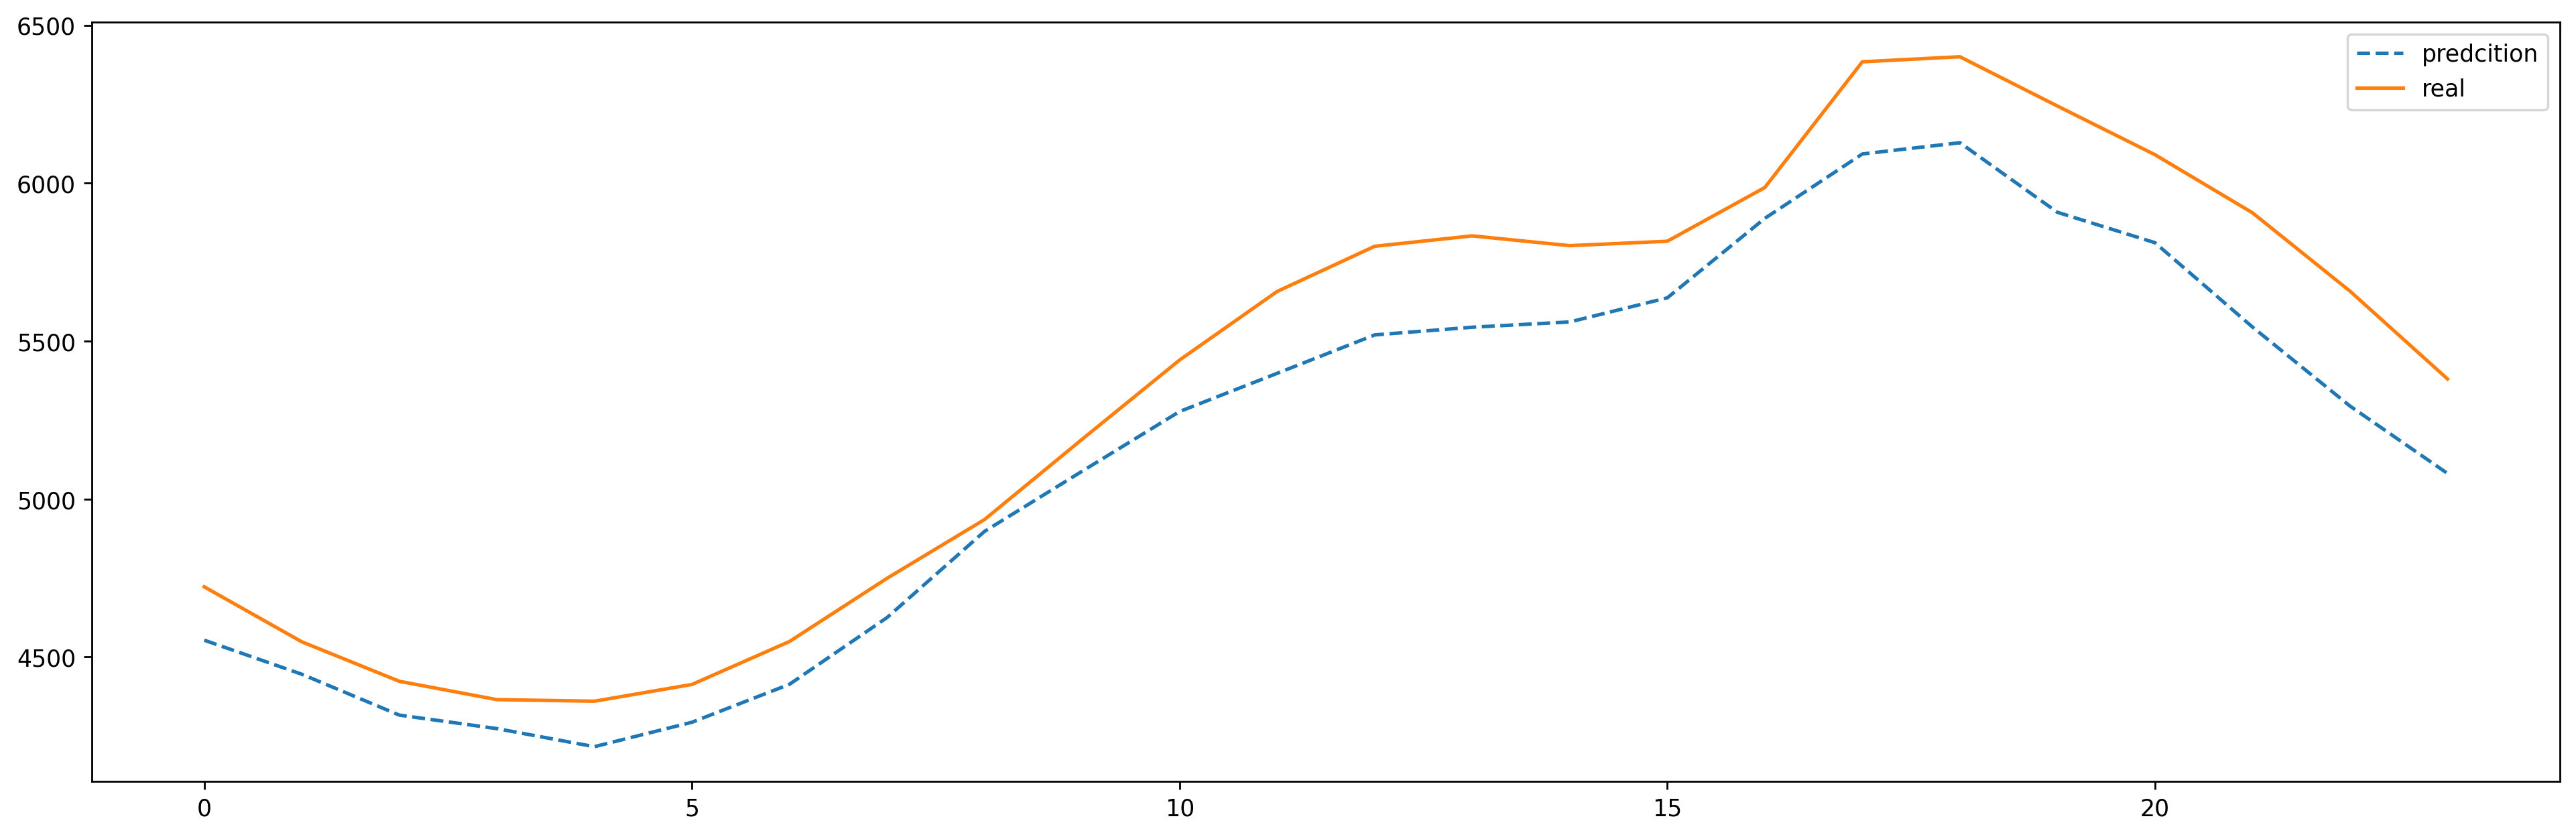

In [34]:
figure(figsize=(19, 6), dpi=250)

j=1*24
dates = range(len(prediction_descaled[j]))
plt.plot(dates[0:24], prediction_descaled[j] , "--", label="predcition")
plt.plot(dates[0:24], values_descaled[j], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();
